#Install necessary versions of packages

In [ ]:
# Install packages if not available yet
!pip install git+https://github.com/devitocodes/devito.git --quiet
!pip install sympy==1.5.1 --quiet
!pip install numpy==1.17.0 --quiet

     |████████████████████████████████| 5.6MB 7.0MB/s 
     |████████████████████████████████| 81kB 9.7MB/s 
     |████████████████████████████████| 102kB 11.8MB/s 
     |████████████████████████████████| 143kB 57.1MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 194kB 54.1MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 71kB 7.7MB/s 
     |████████████████████████████████| 71kB 8.9MB/s 
ERROR: pytest-cov 2.11.1 has requirement coverage>=5.2.1, but you'll have coverage 3.7.1 which is incompatible.
ERROR: pytest-cov 2.11.1 has requirement pytest>=4.6, but you'll have pytest 3.6.4 which is incompatible.
     |████████████████████████████████| 20.3MB 7.1MB/s 
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.17.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentat

#Mount Drive

In [ ]:
!nvidia-smi

Tue Apr 13 12:36:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Devito Integration

In [ ]:
%cd /content/drive/My\ Drive/ML_Ultrasound_Project/UROPdata

/content/drive/My Drive/ML_Ultrasound_Project/UROPdata


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

import pprint
from mpl_toolkits.axes_grid1 import make_axes_locatable

import devito
from sympy import Symbol
from devito import Operator
from devito import Eq, solve
from devito import TimeFunction

import torch
from torch.autograd import Variable
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import nn

from sklearn.preprocessing import MinMaxScaler
import cv2
from scipy import stats
from scipy.ndimage import gaussian_filter

from tqdm.notebook import tqdm

from networks.convlstm import RNN

from medical.plotting import plot_shotrecord, plot_velocity
from medical.source import ToneBurstSource, Receiver
from medical.source import TimeAxis
from medical.model import Model

[[0.1375 0.0175]]


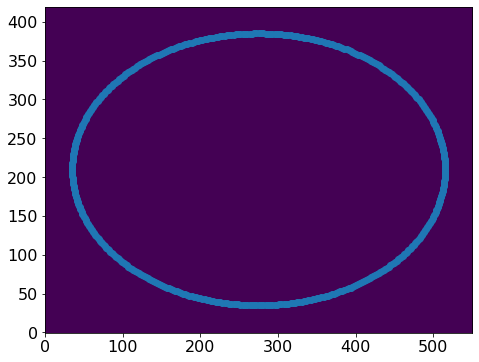

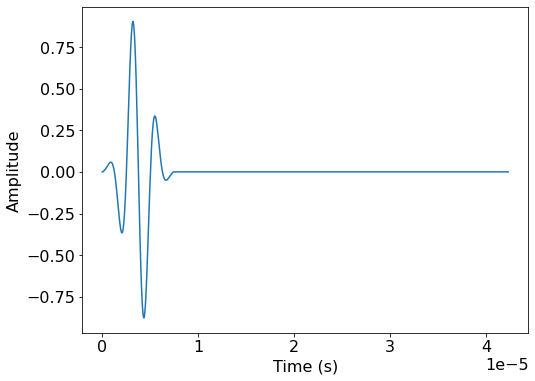

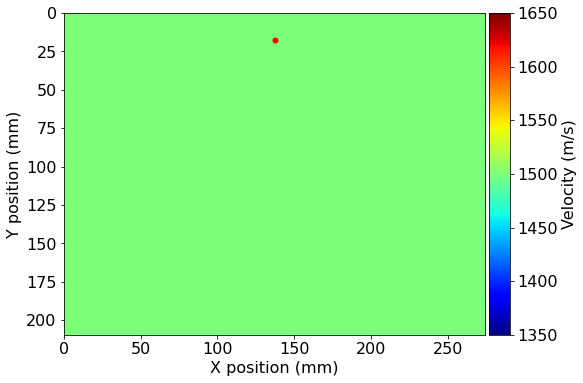

In [ ]:
devito.parameters.configuration['language'] = 'openmp'
devito.parameters.configuration['mpi'] = False

# By changing the src_index you'll be selecting a different source coordinate from the different 512 that have been created
# By changing the model type to water, skull or full you'll get different background mediums
# The cutting box has dimensions of (485, 355) in this case. This cannot change
# The cutting box is centred in the medium
# The complete medium is currently (1001, 1001) but you will have to make this bigger if you need to in order to
# make sure that the wavefield does not come back into the cutting box after hitting the edges of the complete medium

src_index = 256     #256  # From 0 to 512
model_type = 'water'  # water, skull or full
run_type = 'limited'  # infinite, limited

# Infinite will run the operator like when you generated your dataset. When you plot the resulting wavefield
# at the end, 'infinite' will look as if the wave is expanding into infinity. If you run it with 'limited'
# however, you'll see how the wave bounces back against the edge. The goal is to make the 'limited' case
# run as if it was the 'infinite' one by using your network.


def create_eliptic_array(n_sources, boundary_offset, dx, shape):
    a = (shape[1] / 2)
    b = (shape[0] / 2)

    pos = np.empty((2, n_sources), dtype=np.float32)
    angle = np.zeros((n_sources))
    for idx in range(n_sources):
        angle[idx] = ((idx) * 360.0 / n_sources) * 2 * np.pi / 360.0  # transducer angle
        pos[1, idx] = (a * np.cos(angle[idx]) + shape[1] / 2)  # spherical equation of ellipse
        pos[0, idx] = (b * np.sin(angle[idx]) + shape[0] / 2)  # spherical equation of ellipse

    pos[0, :] += boundary_offset[0]
    pos[1, :] += boundary_offset[1]
    pos *= dx
    # np.array((np.divide(grid[0] ** 2, major_ax ** 2) + np.divide(grid[1] ** 2, minor_ax ** 2)) < 1, dtype=np.float32)
    return pos


# Load different types of background models
if model_type == 'water':
    model = np.ones((480, 350)) * 1500.

elif model_type == 'skull':
    model = np.fromfile('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/data/alpha2D-ExactSkull.raw', dtype=np.float32, count=-1)
    model = model.reshape([350, 480])[::1, ::1].transpose()

elif model_type == 'full':
    model = np.fromfile('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/data/alpha2D-TrueVp.raw', dtype=np.float32, count=-1)
    model = model.reshape([350, 480])[::1, ::1].transpose()

y_length = 480+66+4  #480+11
x_length = 350+66+4  #350+11

# Define a physical size
if run_type == 'infinite':
    shape = (1001, 1001)            # Number of grid point (nx, nz) - CHANGE THIS FOR THE MEDIUM SIZE
else:
    shape = (y_length, x_length)
    
spacing = (0.5e-3, 0.5e-3)      # Grid spacing in m.
origin = (0., 0.)               # What is the location of the top left corner. This is necessary to define
                                # the absolute location of the source and receivers

# Define a velocity profile. The velocity is in m/s
diff_x = shape[0] - model.shape[0]
diff_y = shape[1] - model.shape[1]
offset_x = int(np.floor(diff_x/2))
offset_y = int(np.floor(diff_y/2))

model = np.pad(model,
               ((int(np.floor(diff_x/2)), int(np.ceil(diff_x/2))), 
                (int(np.floor(diff_y/2)), int(np.ceil(diff_y/2)))),
               'edge')

plt.imshow(np.transpose(model), origin='lower')

# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=model, origin=origin, shape=shape, spacing=spacing, space_order=4, nbpml=0)

t0 = 0.                 # Simulation starts a t=0
num = 530              # Simulation last number of time steps - CHANGE THIS FOR THE AMOUNT OF TIMESTEPS
dt = 0.08e-6            # Time step from model grid spacing

time_range = TimeAxis(start=t0, num=num, step=dt)

f0 = 0.40e6  # Source peak frequency is 400kHz
src = ToneBurstSource(name='src', grid=model.grid, f0=f0, npoint=1, time_range=time_range)

# First, position source centrally in all dimensions
src_positions = create_eliptic_array(512, (offset_x, offset_y), spacing[0], (480, 350))
src.coordinates.data[0, :] = src_positions[:, src_index]

print(src.coordinates.data)

plt.scatter(src_positions[0, :]/spacing[0], src_positions[1, :]/spacing[1])
plt.show()

# We can plot the time signature to see the wavelet
src.show()

# We can now show the source and receivers within our domain:
# Red dot: Source location
plot_velocity(model, source=src.coordinates.data)

In [ ]:
# In order to represent the wavefield u and the square slowness we need symbolic objects
# corresponding to time-space-varying field (u, TimeFunction) and
# space-varying field (m, Function)

# Define the wavefield with the size of the model and the time dimension
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=4, save=num)

# Create a temporary symbol for H to avoid expensive sympy solve
H = Symbol('H')

# Define PDE
eq = model.m * u.dt2 - H

# Solve the symbolic equation for the field to be updated
eq_time = solve(eq, u.forward)

# Get the spacial FD
biharmonic = u.biharmonic(1/model.m)
laplacian = u.laplace + dt**2/12 * biharmonic

# This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
# Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as
# a time marching updating equation known as a stencil using customized SymPy functions
stencil = Eq(u.forward, eq_time.subs({H: laplacian}))

# Finally we define the source injection function to generate the corresponding code
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)


In [ ]:
# Load trained RNN state dict

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

rnn = RNN()
rnn.to(dev)
rnn.load_state_dict(torch.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/rnn12_state_dict_zeroed_200'))
rnn.eval()

RNN(
  (convlstm1): CLSTM_cell(
    (conv): Sequential(
      (0): Conv2d(33, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(4, 128, eps=1e-05, affine=True)
    )
  )
  (convlstm2): CLSTM_cell(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(4, 128, eps=1e-05, affine=True)
    )
  )
  (convlstm3): CLSTM_cell(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(4, 128, eps=1e-05, affine=True)
    )
  )
  (convlstm4): CLSTM_cell(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(4, 128, eps=1e-05, affine=True)
    )
  )
  (reshape_output): ProcessOut(
    (tanh): Tanh()
    (flat): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=152352, out_features=11, bias=True)
  )
  (lambda_1): Lambda()
)

In [ ]:
def execute_operator(kwargs, time_min=None, time_max=None):
    if time_min is None:
        time_min = 1

    if time_max is None:
        time_max = num-1

    kwargs['time_m'] = time_min
    kwargs['time_M'] = time_max
    
    args = op.arguments(**kwargs)

    arg_values = [args[p.name] for p in op.parameters]
    try:
        op.cfunction(*arg_values)

    except ctypes.ArgumentError as e:
        if e.args[0].startswith("argument "):
            argnum = int(e.args[0][9:].split(':')[0]) - 1
            newmsg = "error in argument '%s' with value '%s': %s" % (
                self._operator.parameters[argnum].name,
                arg_values[argnum],
                e.args[0])
            raise ctypes.ArgumentError(newmsg) from e
        else:
            raise
            
    op._postprocess_arguments(args, **kwargs)


In [ ]:
def preprocess_borders(image0, image1, image2, image3, image4, y_len, x_len):

  image0, image1, image2, image3, image4 = map(torch.cuda.FloatTensor, (image0, image1, image2, image3, image4))

  # top row
  top_row = []
  for i in range(x_len-22):  #create the set for each 23x23 box location
    square_timestep0_T = image0[11:34, i:i+23] #gets the square in terms of i
    square_timestep1_T = image1[11:34, i:i+23]
    square_timestep2_T = image2[11:34, i:i+23]
    square_timestep3_T = image3[11:34, i:i+23]
    square_timestep4_T = image4[11:34, i:i+23]

    #link the 5 images together
    top_row.append(torch.stack((square_timestep0_T, square_timestep1_T, square_timestep2_T, square_timestep3_T, square_timestep4_T), axis = 0)) #save into current_box

  top_row = torch.stack(top_row) #turn boxes list into tensor

  # right column
  right_col = []
  for i in range(y_len-22):  #create the set for each 23x23 box location
    square_timestep0_T = torch.rot90(image0[i:i+23, x_len-11-23:x_len-11], 1) #gets the square in terms of i
    square_timestep1_T = torch.rot90(image1[i:i+23, x_len-11-23:x_len-11], 1)
    square_timestep2_T = torch.rot90(image2[i:i+23, x_len-11-23:x_len-11], 1)
    square_timestep3_T = torch.rot90(image3[i:i+23, x_len-11-23:x_len-11], 1)
    square_timestep4_T = torch.rot90(image4[i:i+23, x_len-11-23:x_len-11], 1)

    #link the 5 images together
    right_col.append(torch.stack((square_timestep0_T, square_timestep1_T, square_timestep2_T, square_timestep3_T, square_timestep4_T), axis = 0)) #save into current_box

  right_col = torch.stack(right_col) #turn boxes list into tensor

  # bottom row
  bot_row = []
  for i in range(x_len-22):  #create the set for each 23x23 box location
    square_timestep0_T = torch.rot90(image0[y_len-11-23:y_len-11, x_len-23-i:x_len-i], 2) #gets the square in terms of i
    square_timestep1_T = torch.rot90(image1[y_len-11-23:y_len-11, x_len-23-i:x_len-i], 2)
    square_timestep2_T = torch.rot90(image2[y_len-11-23:y_len-11, x_len-23-i:x_len-i], 2)
    square_timestep3_T = torch.rot90(image3[y_len-11-23:y_len-11, x_len-23-i:x_len-i], 2)
    square_timestep4_T = torch.rot90(image4[y_len-11-23:y_len-11, x_len-23-i:x_len-i], 2)

    #link the 5 images together
    bot_row.append(torch.stack((square_timestep0_T, square_timestep1_T, square_timestep2_T, square_timestep3_T, square_timestep4_T), axis = 0)) #save into current_box

  bot_row = torch.stack(bot_row) #turn boxes list into tensor

  # left column
  left_col = []
  for i in range(y_len-22):  #create the set for each 23x23 box location
    square_timestep0_T = torch.rot90(image0[y_len-23-i:y_len-i, 11:34], 3) #gets the square in terms of i
    square_timestep1_T = torch.rot90(image1[y_len-23-i:y_len-i, 11:34], 3)
    square_timestep2_T = torch.rot90(image2[y_len-23-i:y_len-i, 11:34], 3)
    square_timestep3_T = torch.rot90(image3[y_len-23-i:y_len-i, 11:34], 3)
    square_timestep4_T = torch.rot90(image4[y_len-23-i:y_len-i, 11:34], 3)

    #link the 5 images together
    left_col.append(torch.stack((square_timestep0_T, square_timestep1_T, square_timestep2_T, square_timestep3_T, square_timestep4_T), axis = 0)) #save into current_box

  left_col = torch.stack(left_col) #turn boxes list into tensor

  borders = torch.vstack((top_row, right_col, bot_row, left_col))

  return borders.to(dev)


In [ ]:
def preprocess_borders9(image0, image1, image2, image3, image4, image5, image6, image7, image8, y_len, x_len):

  image0, image1, image2, image3, image4, image5, image6, image7, image8 = map(torch.cuda.FloatTensor, (image0, image1, image2, image3, image4, image5, image6, image7, image8))

  # top row
  top_row = []
  for i in range(x_len-22):  #create the set for each 23x23 box location
    square_timestep0_T = image0[11:34, i:i+23] #gets the square in terms of i
    square_timestep1_T = image1[11:34, i:i+23]
    square_timestep2_T = image2[11:34, i:i+23]
    square_timestep3_T = image3[11:34, i:i+23]
    square_timestep4_T = image4[11:34, i:i+23]
    square_timestep5_T = image5[11:34, i:i+23]
    square_timestep6_T = image6[11:34, i:i+23]
    square_timestep7_T = image7[11:34, i:i+23]
    square_timestep8_T = image8[11:34, i:i+23]

    #link the 5 images together
    top_row.append(torch.stack((square_timestep0_T, square_timestep1_T, square_timestep2_T, square_timestep3_T, square_timestep4_T,
                                square_timestep5_T, square_timestep6_T, square_timestep7_T, square_timestep8_T), axis = 0)) #save into current_box

  top_row = torch.stack(top_row) #turn boxes list into tensor

  # right column
  right_col = []
  for i in range(y_len-22):  #create the set for each 23x23 box location
    square_timestep0_T = torch.rot90(image0[i:i+23, x_len-11-23:x_len-11], 1) #gets the square in terms of i
    square_timestep1_T = torch.rot90(image1[i:i+23, x_len-11-23:x_len-11], 1)
    square_timestep2_T = torch.rot90(image2[i:i+23, x_len-11-23:x_len-11], 1)
    square_timestep3_T = torch.rot90(image3[i:i+23, x_len-11-23:x_len-11], 1)
    square_timestep4_T = torch.rot90(image4[i:i+23, x_len-11-23:x_len-11], 1)
    square_timestep5_T = torch.rot90(image5[i:i+23, x_len-11-23:x_len-11], 1)
    square_timestep6_T = torch.rot90(image6[i:i+23, x_len-11-23:x_len-11], 1)
    square_timestep7_T = torch.rot90(image7[i:i+23, x_len-11-23:x_len-11], 1)
    square_timestep8_T = torch.rot90(image8[i:i+23, x_len-11-23:x_len-11], 1)

    #link the 5 images together
    right_col.append(torch.stack((square_timestep0_T, square_timestep1_T, square_timestep2_T, square_timestep3_T, square_timestep4_T,
                                square_timestep5_T, square_timestep6_T, square_timestep7_T, square_timestep8_T), axis = 0)) #save into current_box

  right_col = torch.stack(right_col) #turn boxes list into tensor

  # bottom row
  bot_row = []
  for i in range(x_len-22):  #create the set for each 23x23 box location
    square_timestep0_T = torch.rot90(image0[y_len-11-23:y_len-11, x_len-23-i:x_len-i], 2) #gets the square in terms of i
    square_timestep1_T = torch.rot90(image1[y_len-11-23:y_len-11, x_len-23-i:x_len-i], 2)
    square_timestep2_T = torch.rot90(image2[y_len-11-23:y_len-11, x_len-23-i:x_len-i], 2)
    square_timestep3_T = torch.rot90(image3[y_len-11-23:y_len-11, x_len-23-i:x_len-i], 2)
    square_timestep4_T = torch.rot90(image4[y_len-11-23:y_len-11, x_len-23-i:x_len-i], 2)
    square_timestep5_T = torch.rot90(image5[y_len-11-23:y_len-11, x_len-23-i:x_len-i], 2)
    square_timestep6_T = torch.rot90(image6[y_len-11-23:y_len-11, x_len-23-i:x_len-i], 2)
    square_timestep7_T = torch.rot90(image7[y_len-11-23:y_len-11, x_len-23-i:x_len-i], 2)
    square_timestep8_T = torch.rot90(image8[y_len-11-23:y_len-11, x_len-23-i:x_len-i], 2)


    #link the 5 images together
    bot_row.append(torch.stack((square_timestep0_T, square_timestep1_T, square_timestep2_T, square_timestep3_T, square_timestep4_T,
                                square_timestep5_T, square_timestep6_T, square_timestep7_T, square_timestep8_T), axis = 0)) #save into current_box

  bot_row = torch.stack(bot_row) #turn boxes list into tensor

  # left column
  left_col = []
  for i in range(y_len-22):  #create the set for each 23x23 box location
    square_timestep0_T = torch.rot90(image0[y_len-23-i:y_len-i, 11:34], 3) #gets the square in terms of i
    square_timestep1_T = torch.rot90(image1[y_len-23-i:y_len-i, 11:34], 3)
    square_timestep2_T = torch.rot90(image2[y_len-23-i:y_len-i, 11:34], 3)
    square_timestep3_T = torch.rot90(image3[y_len-23-i:y_len-i, 11:34], 3)
    square_timestep4_T = torch.rot90(image4[y_len-23-i:y_len-i, 11:34], 3)
    square_timestep5_T = torch.rot90(image5[y_len-23-i:y_len-i, 11:34], 3)
    square_timestep6_T = torch.rot90(image6[y_len-23-i:y_len-i, 11:34], 3)
    square_timestep7_T = torch.rot90(image7[y_len-23-i:y_len-i, 11:34], 3)
    square_timestep8_T = torch.rot90(image8[y_len-23-i:y_len-i, 11:34], 3)

    #link the 5 images together
    left_col.append(torch.stack((square_timestep0_T, square_timestep1_T, square_timestep2_T, square_timestep3_T, square_timestep4_T,
                                square_timestep5_T, square_timestep6_T, square_timestep7_T, square_timestep8_T), axis = 0)) #save into current_box

  left_col = torch.stack(left_col) #turn boxes list into tensor

  borders = torch.vstack((top_row, right_col, bot_row, left_col))

  return borders.to(dev)


In [ ]:
def get_images(u, t, y_len, x_len):
    
  if t < 12:
    image0 = np.zeros((y_len, x_len))
    image1 = np.zeros((y_len, x_len))
    image2 = np.zeros((y_len, x_len))
    image3 = np.zeros((y_len, x_len))
    image4 = u.data[t]    

  elif t < 24:
    image0 = np.zeros((y_len, x_len))
    image1 = np.zeros((y_len, x_len))
    image2 = np.zeros((y_len, x_len))
    image3 = u.data[t-12]
    image4 = u.data[t]

  elif t < 36:
    image0 = np.zeros((y_len, x_len))
    image1 = np.zeros((y_len, x_len))
    image2 = u.data[t-24]
    image3 = u.data[t-12]
    image4 = u.data[t]

  elif t < 48:
    image0 = np.zeros((y_len, x_len))
    image1 = u.data[t-36]
    image2 = u.data[t-24]
    image3 = u.data[t-12]
    image4 = u.data[t]

  else:
    image0 = u.data[t-48]
    image1 = u.data[t-36]
    image2 = u.data[t-24]
    image3 = u.data[t-12]
    image4 = u.data[t]

  return image0, image1, image2, image3, image4

In [ ]:
def get_images9(u, t, y_len, x_len):
  
  if t < 6:
    image0 = np.zeros((y_len, x_len))
    image1 = np.zeros((y_len, x_len))
    image2 = np.zeros((y_len, x_len))
    image3 = np.zeros((y_len, x_len))
    image4 = np.zeros((y_len, x_len))
    image5 = np.zeros((y_len, x_len))
    image6 = np.zeros((y_len, x_len))
    image7 = np.zeros((y_len, x_len))
    image8 = u.data[t]
    
  elif t < 12:
    image0 = np.zeros((y_len, x_len))
    image1 = np.zeros((y_len, x_len))
    image2 = np.zeros((y_len, x_len))
    image3 = np.zeros((y_len, x_len))
    image4 = np.zeros((y_len, x_len))
    image5 = np.zeros((y_len, x_len))
    image6 = np.zeros((y_len, x_len))
    image7 = u.data[t-6]
    image8 = u.data[t]    

  elif t < 18:
    image0 = np.zeros((y_len, x_len))
    image1 = np.zeros((y_len, x_len))
    image2 = np.zeros((y_len, x_len))
    image3 = np.zeros((y_len, x_len))
    image4 = np.zeros((y_len, x_len))
    image5 = np.zeros((y_len, x_len))
    image6 = u.data[t-12]
    image7 = u.data[t-6]
    image8 = u.data[t]

  elif t < 24:
    image0 = np.zeros((y_len, x_len))
    image1 = np.zeros((y_len, x_len))
    image2 = np.zeros((y_len, x_len))
    image3 = np.zeros((y_len, x_len))
    image4 = np.zeros((y_len, x_len))
    image5 = u.data[t-18]
    image6 = u.data[t-12]
    image7 = u.data[t-6]
    image8 = u.data[t]

  elif t < 30:
    image0 = np.zeros((y_len, x_len))
    image1 = np.zeros((y_len, x_len))
    image2 = np.zeros((y_len, x_len))
    image3 = np.zeros((y_len, x_len))
    image4 = u.data[t-24]
    image5 = u.data[t-18]
    image6 = u.data[t-12]
    image7 = u.data[t-6]
    image8 = u.data[t]

  elif t < 36:
    image0 = np.zeros((y_len, x_len))
    image1 = np.zeros((y_len, x_len))
    image2 = np.zeros((y_len, x_len))
    image3 = u.data[t-30]
    image4 = u.data[t-24]
    image5 = u.data[t-18]
    image6 = u.data[t-12]
    image7 = u.data[t-6]
    image8 = u.data[t]

  elif t < 42:
    image0 = np.zeros((y_len, x_len))
    image1 = np.zeros((y_len, x_len))
    image2 = u.data[t-36]
    image3 = u.data[t-30]
    image4 = u.data[t-24]
    image5 = u.data[t-18]
    image6 = u.data[t-12]
    image7 = u.data[t-6]
    image8 = u.data[t]

  elif t < 48:
    image0 = np.zeros((y_len, x_len))
    image1 = u.data[t-42]
    image2 = u.data[t-36]
    image3 = u.data[t-30]
    image4 = u.data[t-24]
    image5 = u.data[t-18]
    image6 = u.data[t-12]
    image7 = u.data[t-6]
    image8 = u.data[t]

  else:
    image0 = u.data[t-48]
    image1 = u.data[t-42]
    image2 = u.data[t-36]
    image3 = u.data[t-30]
    image4 = u.data[t-24]
    image5 = u.data[t-18]
    image6 = u.data[t-12]
    image7 = u.data[t-6]
    image8 = u.data[t]

  return image0, image1, image2, image3, image4, image5, image6, image7, image8

In [ ]:
def print_border_images(borders, y_len, x_len):
  top_row = borders[0,4,].to('cpu').detach().numpy()
  for i in range(23,x_len-22-1,1):
    top_row = np.append(top_row, borders[i,4,:,11:12].to('cpu').detach().numpy(), axis=1)
  top_row = np.append(top_row, borders[i,4,].to('cpu').detach().numpy(), axis=1)

  r_col = borders[x_len-22,4,].to('cpu').detach().numpy()
  for i in range(23+x_len-22,x_len-22+y_len-22-1,1):
    r_col = np.append(r_col, borders[i,4,:,11:12].to('cpu').detach().numpy(), axis=1)
  r_col = np.append(r_col, borders[i,4,].to('cpu').detach().numpy(), axis=1)

  bot_row = borders[x_len-22+y_len-22,4,].to('cpu').detach().numpy()
  for i in range(23+x_len-22+y_len-22,x_len-22+y_len-22+x_len-22-1,1):
    bot_row = np.append(bot_row, borders[i,4,:,11:12].to('cpu').detach().numpy(), axis=1)
  bot_row = np.append(bot_row, borders[i,4,].to('cpu').detach().numpy(), axis=1)

  l_col = borders[x_len-22+y_len-22+x_len-22,4,].to('cpu').detach().numpy()
  for i in range(23+x_len-22+y_len-22+x_len-22,x_len-22+y_len-22+x_len-22+y_len-22-1,1):
    l_col = np.append(l_col, borders[i,4,:,11:12].to('cpu').detach().numpy(), axis=1)
  l_col = np.append(l_col, borders[i,4,].to('cpu').detach().numpy(), axis=1)

  plt.figure(figsize=(10,10))
  plt.imshow(top_row)
  plt.title('Top row images')
  plt.show()
  plt.figure(figsize=(10,10))
  plt.imshow(r_col)
  plt.title('Right column images')
  plt.show()
  plt.figure(figsize=(10,10))
  plt.imshow(bot_row)
  plt.title('Bottom row images')
  plt.show()
  plt.figure(figsize=(10,10))
  plt.imshow(l_col)
  plt.title('Left column images')
  plt.show()


In [ ]:
def print_border_images_predictions(images, predictions, y_len, x_len):
  # top_border_and_pred = np.append(np.fliplr(images)[:x_len-11], np.fliplr(predictions)[:x_len-11], axis=1)
  # plt.figure(figsize=(20,20))
  # plt.title('Top row images and predictions')
  # plt.yticks([11])
  # plt.imshow(np.rot90(top_border_and_pred))
  # plt.show()
  left_border_and_pred = np.append(np.fliplr(images)[(x_len-11)*2+y_len-11:], np.fliplr(predictions)[(x_len-11)*2+y_len-11:], axis=1)
  plt.figure(figsize=(20,20))
  plt.title('Left column images and predictions (rotated)')
  plt.yticks([11])
  plt.imshow(np.rot90(left_border_and_pred))
  plt.show()

In [ ]:
# Generator
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [ ]:
def preprocess(x):
    return x.view(-1, 9, 1, 23, 23).to(dev)

In [ ]:
# Prepare the operator
u.data.fill(0.)
op = Operator([stencil] + src_term, subs=model.spacing_map)
    
kwargs = {'dt': dt}

sin_dist = 11
edge_damp_array = np.ones((y_length, x_length))
edges = np.reshape(np.linspace(0,1,sin_dist), (sin_dist,1))

sin_edges = []
for i in edges:
  sin_edges.append([math.sin(i*math.pi/2)])

corner = np.matmul(sin_edges, np.transpose(sin_edges))

edge_damp_array[:sin_dist, :] = np.repeat(sin_edges, edge_damp_array.shape[1], axis=1)
edge_damp_array[edge_damp_array.shape[0]-sin_dist:, :] = np.rot90(np.repeat(sin_edges, edge_damp_array.shape[1], axis=1),2)
edge_damp_array[:,:sin_dist] = np.rot90(np.repeat(sin_edges, edge_damp_array.shape[0], axis=1))
edge_damp_array[:,edge_damp_array.shape[1]-sin_dist:] = np.rot90(np.repeat(sin_edges, edge_damp_array.shape[0], axis=1),3)
edge_damp_array[:sin_dist,:sin_dist] = corner
edge_damp_array[:sin_dist, edge_damp_array.shape[1]-sin_dist:] = np.rot90(corner, 3)
edge_damp_array[edge_damp_array.shape[0]-sin_dist:, :sin_dist] = np.rot90(corner, 1)
edge_damp_array[edge_damp_array.shape[0]-sin_dist:, edge_damp_array.shape[1]-sin_dist:] = np.rot90(corner, 2)

# Execute the operator
for t in tqdm(range(1, num-2)):
    execute_operator(kwargs, t, t+1)

    image0, image1, image2, image3, image4, image5, image6, image7, image8 = get_images9(u, t+1, y_length, x_length)

    # borders = preprocess_borders(image0, image1, image2, image3, image4, y_length, x_length)
    borders = preprocess_borders9(image0, image1, image2, image3, image4, image5, image6, image7, image8, y_length, x_length)

    # norm_borders = (((borders - -7.546365e-08) / (8.9908006e-08 - -7.546365e-08))).to(dev)    # Normalised using same parameters as training data
    zeroed_borders = borders/8.9908006e-08

    # print_border_images(norm_borders, y_length, x_length)     # Function to display just border images to check formatting (inputs to cnn)

    ds = TensorDataset(zeroed_borders)
    dl = DataLoader(ds, batch_size=len(zeroed_borders))
    dl = WrappedDataLoader(dl, preprocess)

    predictions = []
    for x in dl:
      with torch.no_grad():
          # pred = cnn(x).squeeze(0)
          # tanh_pred = tanh_cnn(x).squeeze(0) #(tanh_cnn(x*2-1).squeeze(0)+1)/2
          # total_pred = torch.add(pred, tanh_pred)/2
          rnn_pred = rnn(x).squeeze(0)
          # un_norm_pred = tanh_pred*(8.9908006e-08 - -7.546365e-08) + -7.546365e-08     # 'Un-normalised' using same parameters as training data
          # un_zeroed_pred = tanh_pred*8.9908006e-08
          un_zeroed_pred = rnn_pred*8.9908006e-08
          predictions.append(un_zeroed_pred.cpu().detach().numpy())

    images = borders[:,4,:,11:12].cpu().detach().numpy().squeeze()
    predictions = np.reshape(predictions, (-1,11))

    # print_border_images_predictions(images, predictions, y_length, x_length)     # Function to display images and predicted borders to check formatting

    v = np.copy(u.data[t+1])

    v[:11,11:x_length-11] = np.fliplr(np.rot90(predictions[:x_length-22], 3))
    v[11:y_length-11,x_length-11:] = np.rot90(predictions[x_length-22:x_length-22+y_length-22], 2)
    v[y_length-11:,11:x_length-11] = np.fliplr(np.rot90(predictions[x_length-22+y_length-22:x_length-22+y_length-22+x_length-22], 1))
    v[11:y_length-11,:11] = np.flipud(predictions[x_length-22+y_length-22+x_length-22:])

    # sig = 0.2
    # v[:21,:] = gaussian_filter(v[:21,:], sigma=sig)
    # v[21:y_length-21,:21] = gaussian_filter(v[21:y_length-21,:21], sigma=sig)
    # v[y_length-21:,:] = gaussian_filter(v[y_length-21:,:], sigma=sig)
    # v[21:y_length-21:,x_length-21:] = gaussian_filter(v[21:y_length-21:,x_length-21:], sigma=sig)



    print('=========================================================================================================')
    print('Timestep ',t)

    # print('Zero Errors: ')
    # print(*v[400,:30])

    # print('Zero Errors (centre):')
    # print(*v[273,:30])


    fig, ax = plt.subplots(1,2, figsize=(25,20))

    divider = make_axes_locatable(ax[0])
    cax0 = divider.append_axes("right", size="5%", pad=0.05)
    ax[0].set_title('Zero Errors ([400,:34])')
    ax[0].set_xticks([11])
    im0 = ax[0].imshow(v[400:410,:34])
    fig.colorbar(im0, cax=cax0)

    divider = make_axes_locatable(ax[1])
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    ax[1].set_title('Zero Errors (centre)')
    ax[1].set_xticks([11])
    im1 = ax[1].imshow(v[270:280,:34])
    fig.colorbar(im1, cax=cax1)
    plt.show()


    # v *= edge_damp_array

    plt.figure(figsize=(25,20))
    plt.title('Left column images and substituted predictions (rotated)')
    plt.yticks([11])
    plt.imshow(np.rot90(v[:,:50], 3))
    plt.show()

    # fig, ax = plt.subplots(1,2, figsize=(25,20))

    # divider = make_axes_locatable(ax[0])
    # cax0 = divider.append_axes("right", size="5%", pad=0.05)
    # ax[0].set_title('Zero Errors w/ SD ([400,:40])')
    # ax[0].set_xticks([11])
    # im0 = ax[0].imshow(v[400:410,:40])
    # fig.colorbar(im0, cax=cax0)

    # divider = make_axes_locatable(ax[1])
    # cax1 = divider.append_axes("right", size="5%", pad=0.05)
    # ax[1].set_title('Zero Errors w/ SD (centre)')
    # ax[1].set_xticks([11])
    # im1 = ax[1].imshow(v[268:278,:40])
    # fig.colorbar(im1, cax=cax1)
    # plt.show()

    # plt.figure(figsize=(10,10))
    # plt.title('substituted borders, timestep = {}'.format(t))
    # plt.imshow(v)
    # plt.colorbar()
    # plt.show()

    # # Conversion of image to grayscale for thresholding
    # scaler = MinMaxScaler(feature_range=[0,255])
    # img = np.array(scaler.fit_transform(np.abs(v)), dtype = np.uint8)

    # # calculate threshold using Otsu's method
    # th, thresh_im = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  
    # # plt.figure()
    # # plt.title('Otsu')
    # # plt.imshow(thresh_im)
    # # plt.show()

    # grown_img = np.copy(thresh_im)

    # win_size = 6  # Window size
    # for i in range(win_size,thresh_im.shape[0]-win_size,1):
    #   for j in range(win_size,thresh_im.shape[1]-win_size,1):
    #     if thresh_im[i,j] == 255:
    #       grown_img[i-6:i+6, j-2:j+3] = 255
    #       grown_img[i-5:i+5, j-4:j-2] = 255
    #       grown_img[i-5:i+5, j+3:j+5] = 255
    #       grown_img[i-4:i+4, j-5] = 255
    #       grown_img[i-4:i+4, j+5] = 255
    #       grown_img[i-2:i+2, j-6] = 255
    #       grown_img[i-2:i+2, j+6] = 255


    # plt.figure()
    # plt.title('Grown Img')
    # plt.imshow(grown_img)
    # plt.show()

    # num_labels, labels = cv2.connectedComponents(grown_img)
    # labels = labels

    # # plt.figure()
    # # plt.imshow(labels)
    # # plt.show()

    # # Get indices of all pixels in regions that are not a wave
    # # Set values in that region to the mean for that region
    # for i in range(num_labels):
    #   coords = np.where(labels == i)
    #   coords_list = list(zip(coords[0], coords[1]))
    #   if grown_img[coords_list[0]] != 255:
    #     values = []
    #     for xy in coords_list:
    #       values.append(v[xy])
    #     mode_num = stats.mode(values, axis=None)[0][0]
    #     for xy in coords_list:
    #       v[xy] = (mode_num + v[xy]*4)/5

    u.data[t+1] = v


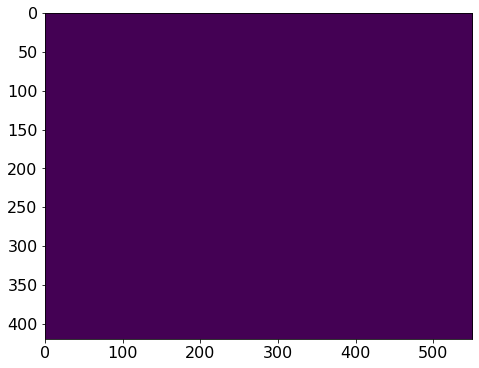

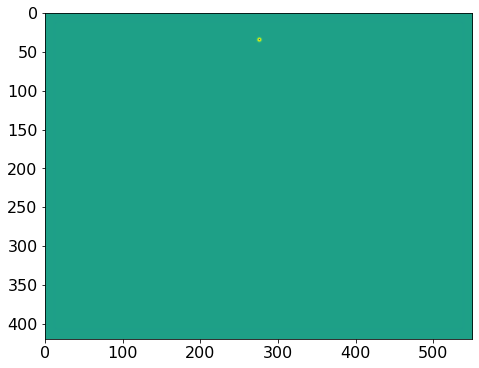

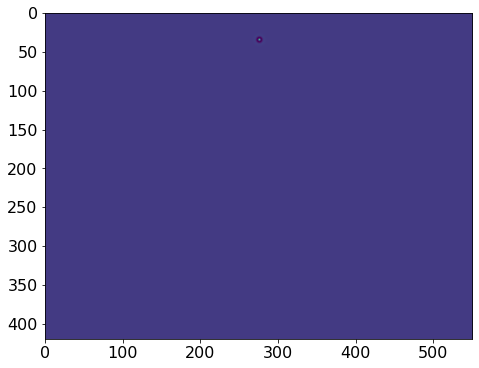

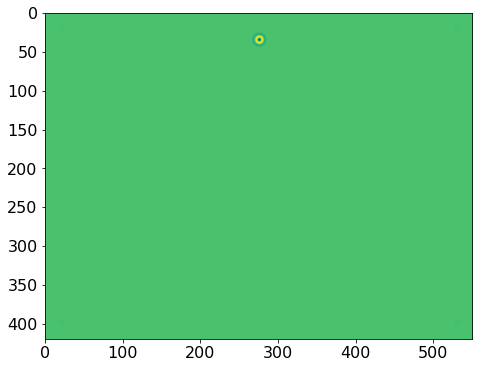

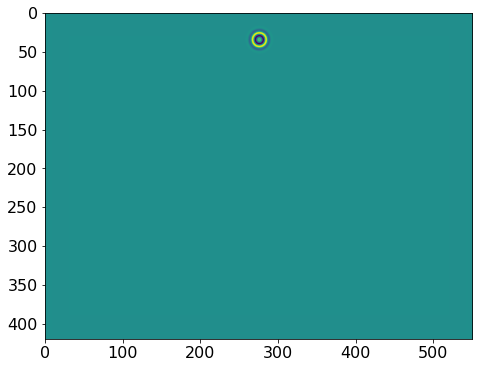

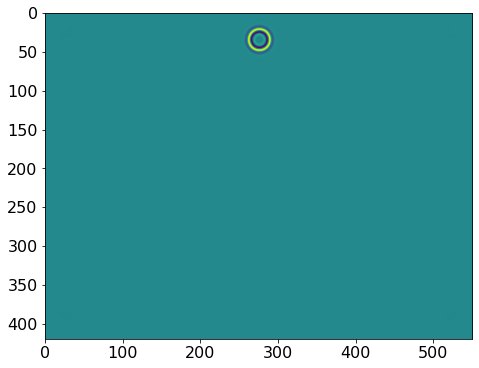

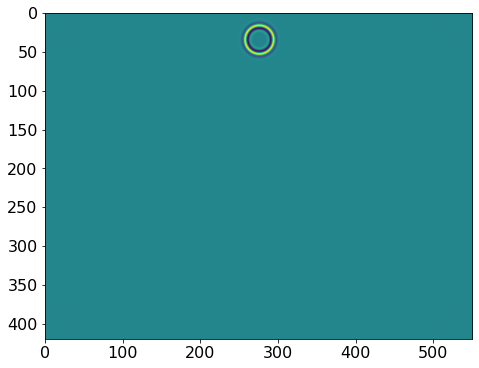

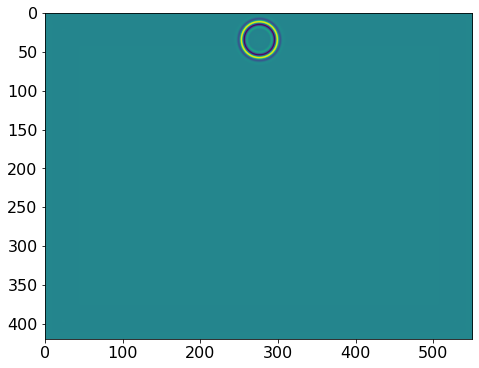

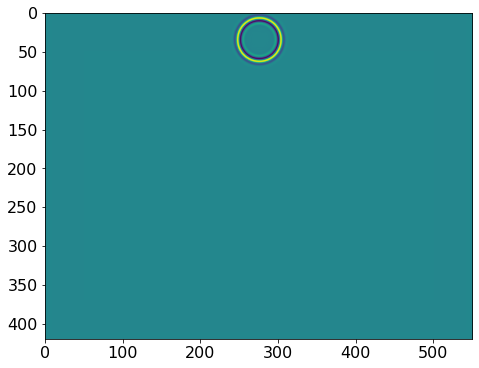

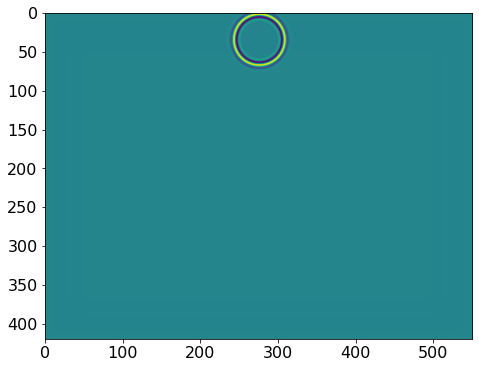

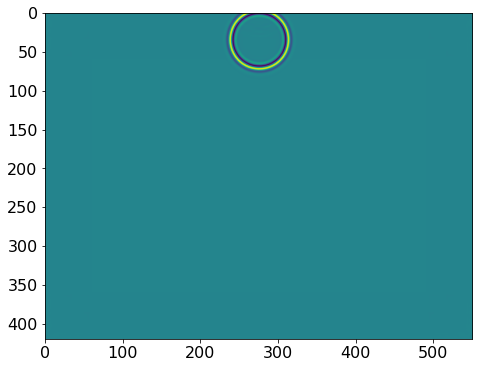

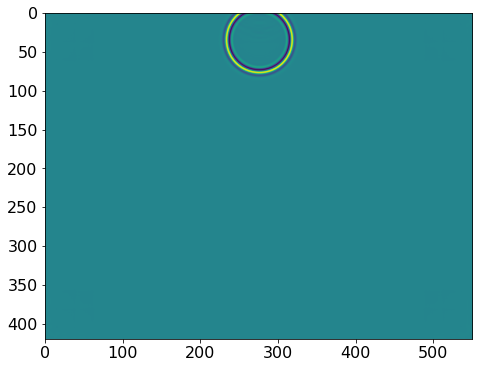

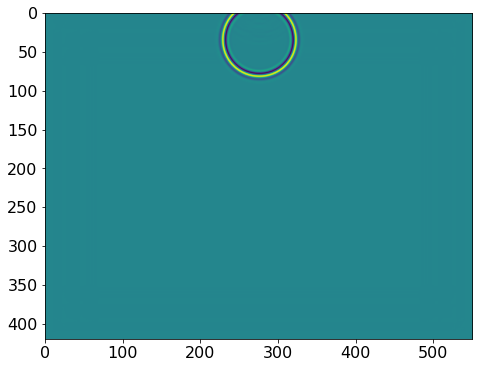

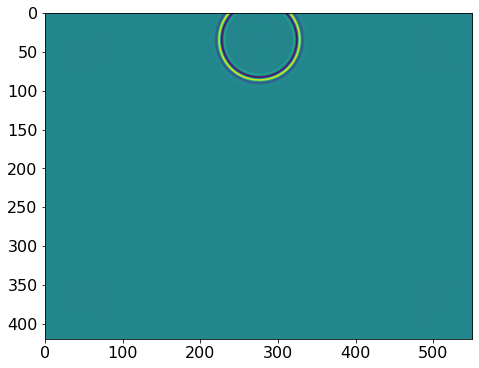

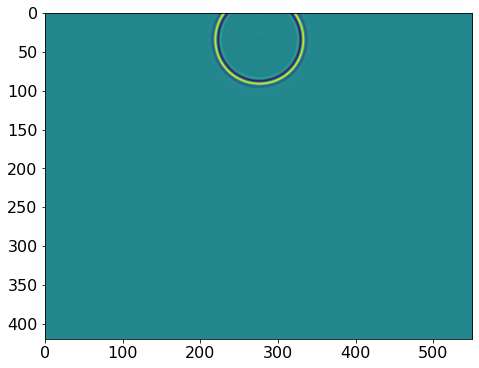

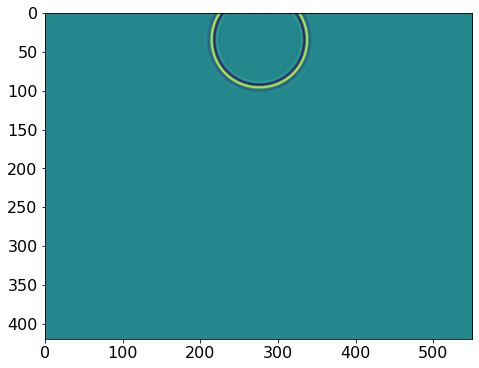

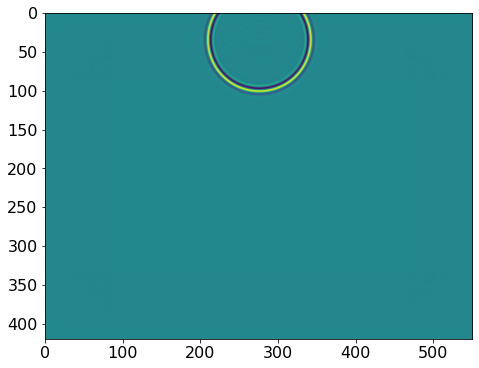

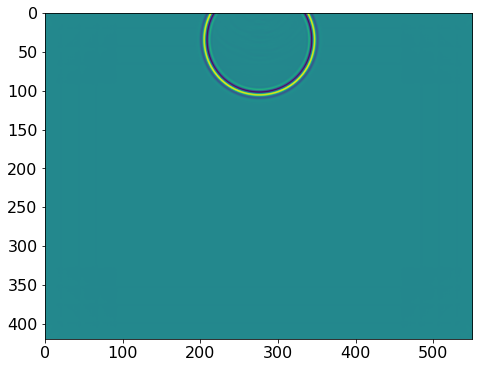

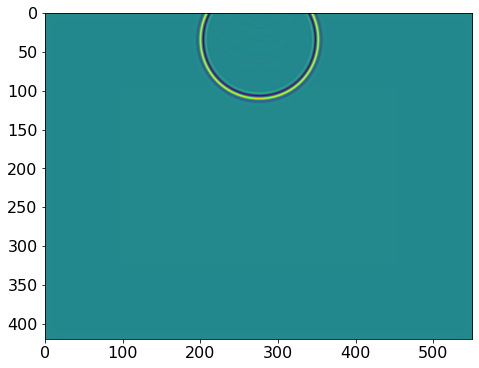

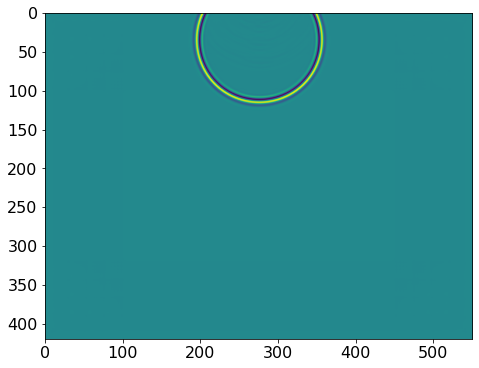

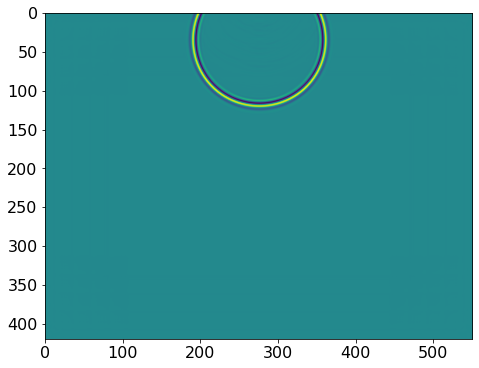

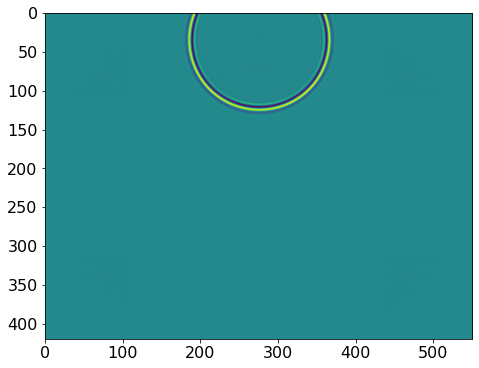

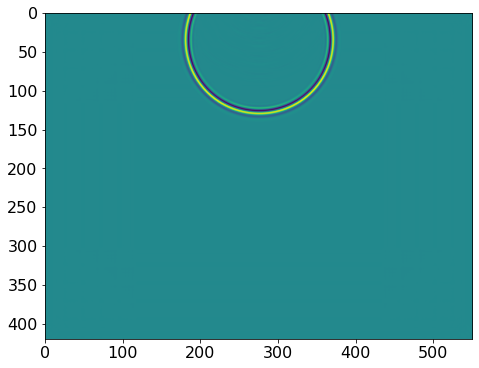

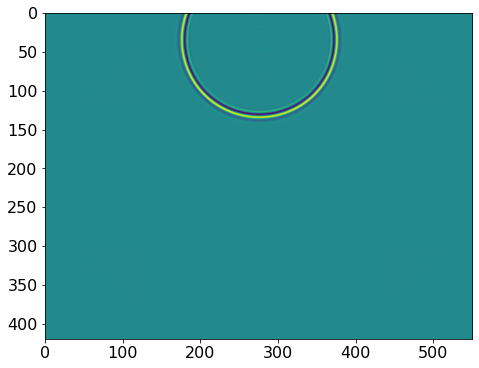

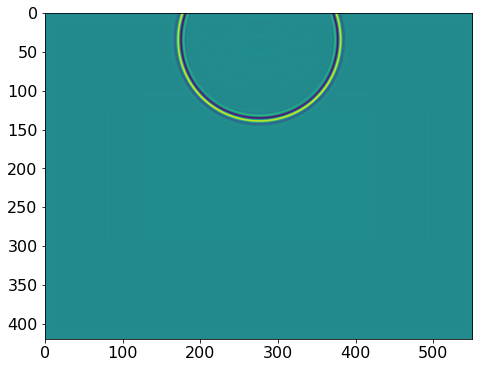

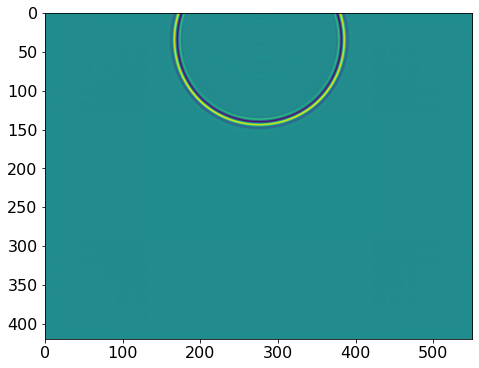

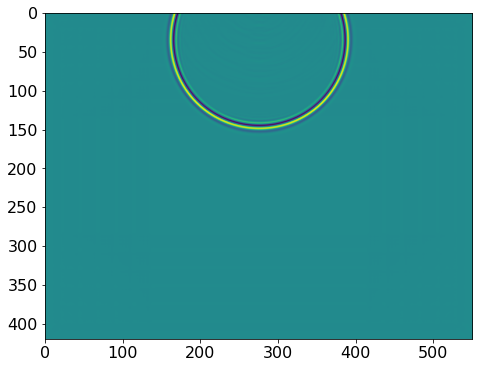

In [ ]:
# Plot the results, every 20 timesteps for now
for t in range(0, num, 20):    
    if run_type == 'infinite':
        slices = (slice(255, -255), slice(320, -320))
    else:
        slices = (slice(0, None), slice(0, None))
    
    plt.imshow(np.transpose(u.data[t][slices]))
    plt.show()